## Loading and Preprocessing the data

In [5]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np
import scipy.io

# Load feature matrices
data_smooth = scipy.io.loadmat("feature_extraction/features_shog_smooth.mat")
data_hard = scipy.io.loadmat("feature_extraction/features_shog_hard.mat")

# Extract feature matrix 'A'
A = data_smooth['A']  # Use 'A' from data_smooth

# Extract different parts
y = A[:, 0]  # First column: Category ID
partitions = A[:, 1]  # Second column: Partition ID
features = A[:, 2:]   # Remaining columns: Feature vectors

# Extract partition ID (2nd column)
partition_id = A[:, 1].astype(int)  # Use the second column of 'A'

# Extract feature vectors (columns 3-502)
X = A[:, 2:]  # Use soft features from 'A'

print(X.shape)
print(X)

(20000, 500)
[[5.47576e-07 2.18018e-04 6.82831e-04 ... 1.31739e-08 3.05126e-03
  6.77268e-05]
 [9.12378e-08 8.82972e-03 5.55477e-08 ... 7.10457e-03 6.00985e-03
  1.05555e-19]
 [2.41255e-13 1.64051e-03 1.65868e-13 ... 2.07955e-02 5.59236e-03
  7.93542e-17]
 ...
 [4.97004e-02 6.89885e-05 2.43204e-03 ... 1.37911e-12 8.27413e-03
  4.50699e-04]
 [1.46880e-02 1.06490e-10 4.13034e-03 ... 1.63214e-10 1.13179e-02
  1.64448e-04]
 [2.27560e-03 5.28743e-08 7.49101e-03 ... 4.23862e-07 1.69976e-03
  1.53205e-04]]


### Normalizing the features

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

### Splitting the dataset

In [10]:
from sklearn.model_selection import train_test_split

# Use partitions 1-8 for training and 9-10 for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Training SVM

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM with RBF Kernel
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")


SVM Accuracy: 0.4935


### Training an ANN model

In [15]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Use partitions 1-8 for training and 9-10 for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization

# Flatten the training and test sets for ANN
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test_flat  = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Define your ANN model (input shape should be (500,))
ann_model = Sequential([
    Dense(1024, activation='relu', input_shape=(500,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(250, activation='softmax')
])

ann_model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Train the ANN model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_ann_model.h5", monitor='val_accuracy', save_best_only=True)
]

history = ann_model.fit(X_train_flat, y_train, 
                        validation_data=(X_test_flat, y_test),
                        epochs=50, 
                        batch_size=64, 
                        callbacks=callbacks, 
                        verbose=1)

# Load best weights (if you saved them)
ann_model.load_weights('best_ann_model.h5')

# Evaluate the ANN model
ann_accuracy = ann_model.evaluate(X_test_flat, y_test, verbose=0)[1]
print(f"ANN Accuracy: {ann_accuracy:.4f}")


Epoch 1/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1365 - loss: 4.5713

250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.1371 - loss: 4.5653 - val_accuracy: 0.3690 - val_loss: 4.1548
Epoch 2/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4205 - loss: 2.4608

250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4205 - loss: 2.4607 - val_accuracy: 0.4465 - val_loss: 2.4877
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5188 - loss: 1.9310

250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5188 - loss: 1.9312 - val_accuracy: 0.4773 - val_loss: 2.2135
Epoch 4/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5769 - loss: 1.6029

250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5767 - loss: 1.6037 - val_accuracy: 0.4798 - val_loss: 2.2097
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6345 - loss: 1.3392

250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.6344 - loss: 1.3395 - val_accuracy: 0.4910 - val_loss: 2.2103
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6847 - loss: 1.1404

250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.6846 - loss: 1.1407 - val_accuracy: 0.4955 - val_loss: 2.1951
Epoch 7/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7225 - loss: 0.9772

250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7223 - loss: 0.9778 - val_accuracy: 0.5100 - val_loss: 2.2075
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7502 - loss: 0.8486

250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7501 - loss: 0.8489 - val_accuracy: 0.5117 - val_loss: 2.3088
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7727 - loss: 0.7528

250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7726 - loss: 0.7531 - val_accuracy: 0.5153 - val_loss: 2.3042
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7974 - loss: 0.6689 - val_accuracy: 0.5092 - val_loss: 2.3721
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8095 - loss: 0.6231 - val_accuracy: 0.5110 - val_loss: 2.4234
ANN Accuracy: 0.5153


### CNN

In [27]:
X_train_reshaped = X_train.reshape(-1, 20, 25, 1)  # Reshape for CNN
X_test_reshaped = X_test.reshape(-1, 20, 25, 1)

# Print shape to verify
print(X_train_reshaped.shape)  # (16000, 20, 25, 1)

(16000, 20, 25, 1)


In [32]:
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

# # Define CNN model
# cnn_model = Sequential([
#     Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(20, 25, 1)),
#     MaxPooling2D(pool_size=(2,2)),
#     Conv2D(64, kernel_size=(3,3), activation='relu'),
#     MaxPooling2D(pool_size=(2,2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(250, activation='softmax')  # 250 classes
# ])

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

cnn_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(20, 25, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(250, activation='softmax')  # 250 classes
])

# Compile model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adjust labels to be in the range [0, 249]
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Train CNN
cnn_model.fit(X_train_reshaped, y_train_adjusted, epochs=20, batch_size=64, validation_data=(X_test_reshaped, y_test_adjusted))

# Evaluate
cnn_accuracy = cnn_model.evaluate(X_test_reshaped, y_test_adjusted, verbose=0)[1]
print(f"CNN Accuracy: {cnn_accuracy:.4f}")


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.0070 - loss: 5.4873 - val_accuracy: 0.0655 - val_loss: 4.7189
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.0858 - loss: 4.4972 - val_accuracy: 0.1637 - val_loss: 3.9798
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.1639 - loss: 3.8991 - val_accuracy: 0.2190 - val_loss: 3.6838
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.2157 - loss: 3.5606 - val_accuracy: 0.2645 - val_loss: 3.4526
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2486 - loss: 3.3164 - val_accuracy: 0.2808 - val_loss: 3.3356
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2892 - loss: 3.1232 - val_accuracy: 0.2965 - val_loss: 3.2473
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3042 - loss: 2.9814 - val_accuracy: 0.3262 - val_loss: 3.1156
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.3448 - loss: 2.7654 - val_acc

In [39]:
print(f"Final Model Accuracies:")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"ANN Accuracy: {ann_accuracy:.4f}")
print(f"CNN Accuracy: {cnn_accuracy:.4f}")

Final Model Accuracies:
SVM Accuracy: 0.4935
ANN Accuracy: 0.5010
CNN Accuracy: 0.3623


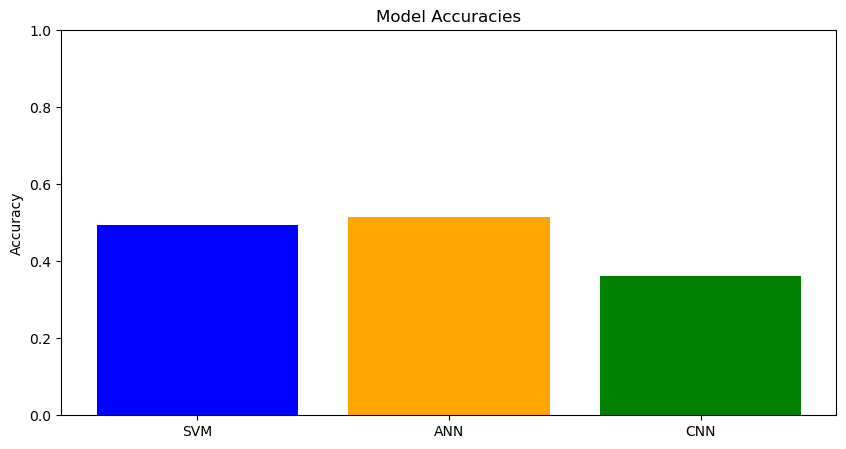

In [46]:
# comparing the accuracies of the three models
import matplotlib.pyplot as plt

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.bar(['SVM', 'ANN', 'CNN'], [svm_accuracy, ann_accuracy, cnn_accuracy], color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')  
plt.title('Model Accuracies')
plt.show()